In [6]:
from pathlib import Path

import torch

In [2]:
!pwd

/gpfs/projects/b1171/ylk4626/project/Chimera/notebooks


In [3]:
# project_path = Path("/projects/b1171/ylk4626/project/Chimera")
project_path = Path("../")

# Load Data from fq

In [4]:
from needletail import parse_fastx_file


def read_records(fastq):
    if isinstance(fastq, Path):
        fastq = fastq.as_posix()
    return list(parse_fastx_file(fastq))

In [5]:
dataset_folder = project_path / "data/train_data/80000"

In [6]:
train_data_path = dataset_folder / "train.fq.target.fq.gz"
val_data_path = dataset_folder / "val.fq.target.fq.gz"
test_data_path = dataset_folder / "test.fq.target.fq.gz"

In [7]:
train_data = read_records(test_data_path)

In [8]:
train_data[0].seq

'GGTAGGCGGGTTTCAGGGGCTCTTTGGTGAAGAGTTTTATGGCGTCAGCGAAGGGTTGTAGTAGCCCGTAGGGGCCTACAACGTTGGGGCCTTTGCGTAGTTGCTGTATCGCCTAGAATTTTTCGTTCGGTAAGCATTAGGAATGCCATTGCGATTAGAATGGGTACAATGAGGAGTAGGAGGTTGGCCATGGGTATGTTGTTAAGAAGAGGAATTGAACCTCTGACTGTAAAGTTTTAAGTTTTATGCGATTACCGGGCTCTGCCATCTTAACAAACCCCTGTTCTTGGGTGGGTGTGGGTATAATGCTAAGTTGAGATGATATCATTTACGGGGGAAGGCGCTTTGTGAAGTAGGCCTTATTTCTCTTGTCCTTTCGTACAGGGAGGAATTTGAAGTAGATAGAAACCGACCTGGATTACTCCGGTCTGAACTCAGATCACGTAGGACTTTAATGGTTGAACAAACGAACCTTTAATAGCGGCTGCACCATTGGGATGTCCTGATCCAACATCGAGGTCGTAAACCCTATTGTTGATATGGACTCTAGATAGGATTGCGCTGTTATCCCTAGGGTAACTTGTTCCGTTGGTCAAGTTATTGGATCAATTGAGTATAGTAGTTCGCTTTGACTGGTGAAGTCTTAGCATGTACTGCTCGGAGGTTGGGTTCTGCTCCGAGGTCGCCCCAACCGAAATTTTTAGATGCCGGTTTGGTCGTTTAGGACCTGTGGGTTTGTTAGGTACTGTTTGCATTAATAAATTAAAGCTCCATAGGGTCTTCTCGTCTTGCTGTGTCATGCCCGCCTCTTCACGGGCAGGTCAATTTCACTGGTTAAAAGTAAGAGACAGCTGAACCCTCGTGGAGCCATTCATACAGGTCCCTATTTAAGGAACAAGTGATTATGCTACCTTTGCACGGTTAGGGTACCAGGACCATTAAACATGTGTCACTGGGCAGGCGGTGCCTGATACTGGTGATGCTAGAGGTGATGTTTTT

In [9]:
from deepbiop import fq

id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}


def parse_target(name):
    """Parse the target name to get the name and the target."""
    rid, target = name.split("|")
    return rid, int(target)


def encode_qual(qual, offset=33):
    """Encode the quality score."""
    return list(fq.encode_qual(qual, offset))

In [52]:
from datasets import load_dataset

data_files = {
    "train": (dataset_folder / "test.fq.target.fq.parquet").as_posix(),
}

train_dataset = load_dataset(
    "parquet",
    data_files=data_files,
    num_proc=2,
).with_format("torch")

Setting num_proc from 2 back to 1 for the train split to disable multiprocessing as it only contains one shard.


Generating train split: 0 examples [00:00, ? examples/s]

In [53]:
train_dataset["train"][0]

{'id': '349022f1-b68c-447e-bf8d-79d9e4c939ee|0',
 'seq': 'GGTAGGCGGGTTTCAGGGGCTCTTTGGTGAAGAGTTTTATGGCGTCAGCGAAGGGTTGTAGTAGCCCGTAGGGGCCTACAACGTTGGGGCCTTTGCGTAGTTGCTGTATCGCCTAGAATTTTTCGTTCGGTAAGCATTAGGAATGCCATTGCGATTAGAATGGGTACAATGAGGAGTAGGAGGTTGGCCATGGGTATGTTGTTAAGAAGAGGAATTGAACCTCTGACTGTAAAGTTTTAAGTTTTATGCGATTACCGGGCTCTGCCATCTTAACAAACCCCTGTTCTTGGGTGGGTGTGGGTATAATGCTAAGTTGAGATGATATCATTTACGGGGGAAGGCGCTTTGTGAAGTAGGCCTTATTTCTCTTGTCCTTTCGTACAGGGAGGAATTTGAAGTAGATAGAAACCGACCTGGATTACTCCGGTCTGAACTCAGATCACGTAGGACTTTAATGGTTGAACAAACGAACCTTTAATAGCGGCTGCACCATTGGGATGTCCTGATCCAACATCGAGGTCGTAAACCCTATTGTTGATATGGACTCTAGATAGGATTGCGCTGTTATCCCTAGGGTAACTTGTTCCGTTGGTCAAGTTATTGGATCAATTGAGTATAGTAGTTCGCTTTGACTGGTGAAGTCTTAGCATGTACTGCTCGGAGGTTGGGTTCTGCTCCGAGGTCGCCCCAACCGAAATTTTTAGATGCCGGTTTGGTCGTTTAGGACCTGTGGGTTTGTTAGGTACTGTTTGCATTAATAAATTAAAGCTCCATAGGGTCTTCTCGTCTTGCTGTGTCATGCCCGCCTCTTCACGGGCAGGTCAATTTCACTGGTTAAAAGTAAGAGACAGCTGAACCCTCGTGGAGCCATTCATACAGGTCCCTATTTAAGGAACAAGTGATTATGCTACCTTTGCACGGTTAGGGTACCAGGACCATTAA

In [54]:
from pathlib import Path

from transformers import PreTrainedTokenizer


class Tokenizer(PreTrainedTokenizer):
    model_input_names = ["input_ids"]

    def __init__(
        self,
        model_max_length: int,
        bos_token="[BOS]",
        eos_token="[SEP]",
        sep_token="[SEP]",
        cls_token="[CLS]",
        pad_token="[PAD]",
        mask_token="[MASK]",
        unk_token="[UNK]",
        **kwargs,
    ):
        """Character tokenizer for Hugging Face transformers.

        Args:
            characters (Sequence[str]): List of desired characters. Any character which
                is not included in this list will be replaced by a special token called
                [UNK] with id=6. Following are list of all of the special tokens with
                their corresponding ids:
                    "[CLS]": 0
                    "[SEP]": 1
                    "[BOS]": 2
                    "[MASK]": 3
                    "[PAD]": 4
                    "[RESERVED]": 5
                    "[UNK]": 6
                an id (starting at 7) will be assigned to each character.
            model_max_length (int): Model maximum sequence length.
        """
        self.characters = ("A", "C", "G", "T", "N")
        self.model_max_length = model_max_length

        self._vocab_str_to_int = {
            "[CLS]": 0,
            "[SEP]": 1,
            "[BOS]": 2,
            "[MASK]": 3,
            "[PAD]": 4,
            "[RESERVED]": 5,
            "[UNK]": 6,
            **{ch: i + 7 for i, ch in enumerate(self.characters)},
        }
        self._vocab_int_to_str = {v: k for k, v in self._vocab_str_to_int.items()}
        add_prefix_space = kwargs.pop("add_prefix_space", False)
        padding_side = kwargs.pop("padding_side", "right")

        super().__init__(
            bos_token=bos_token,
            eos_token=eos_token,
            sep_token=sep_token,
            cls_token=cls_token,
            pad_token=pad_token,
            mask_token=mask_token,
            unk_token=unk_token,
            add_prefix_space=add_prefix_space,
            model_max_length=model_max_length,
            padding_side=padding_side,
            **kwargs,
        )

    @property
    def vocab_size(self) -> int:
        return len(self._vocab_str_to_int)

    def _tokenize(self, text: str) -> list[str]:
        return list(text)

    def _convert_token_to_id(self, token: str) -> int:
        return self._vocab_str_to_int.get(token, self._vocab_str_to_int["[UNK]"])

    def _convert_id_to_token(self, index: int) -> str:
        return self._vocab_int_to_str[index]

    def convert_tokens_to_string(self, tokens):
        return "".join(tokens)

    def get_special_tokens_mask(
        self,
        token_ids_0: list[int],
        token_ids_1: list[int] | None = None,
        *,
        already_has_special_tokens: bool = False,
    ) -> list[int]:
        if already_has_special_tokens:
            return super().get_special_tokens_mask(
                token_ids_0=token_ids_0,
                token_ids_1=token_ids_1,
                already_has_special_tokens=True,
            )

        result = ([0] * len(token_ids_0)) + [1]
        if token_ids_1 is not None:
            result += ([0] * len(token_ids_1)) + [1]
        return result

    def build_inputs_with_special_tokens(
        self, token_ids_0: list[int], token_ids_1: list[int] | None = None
    ) -> list[int]:
        sep = [self.sep_token_id]
        cls = [self.cls_token_id]
        result = cls + token_ids_0 + sep
        if token_ids_1 is not None:
            result += token_ids_1 + sep
        return result

    def get_vocab(self) -> dict[str, int]:
        return self._vocab_str_to_int

    def decode(self, token_ids, skip_special_tokens=False, **kwargs):
        """Decode ids back to sequence string."""
        if isinstance(token_ids, dict):
            token_ids = token_ids["input_ids"]

        if isinstance(token_ids, torch.Tensor):
            token_ids = token_ids.tolist()

        if isinstance(token_ids, list) and isinstance(token_ids[0], list):
            token_ids = token_ids[0]  # Take first sequence if batch

        tokens = [self._convert_id_to_token(id) for id in token_ids["input_ids"]]
        if skip_special_tokens:
            tokens = [token for token in tokens if token not in self.all_special_tokens]

        return self.convert_tokens_to_string(tokens)

In [55]:
tokenizer = Tokenizer(model_max_length=100000)

In [56]:
tokenizer(train_dataset["train"][0]["seq"])

{'input_ids': [0, 9, 9, 10, 7, 9, 9, 8, 9, 9, 9, 10, 10, 10, 8, 7, 9, 9, 9, 9, 8, 10, 8, 10, 10, 10, 9, 9, 10, 9, 7, 7, 9, 7, 9, 10, 10, 10, 10, 7, 10, 9, 9, 8, 9, 10, 8, 7, 9, 8, 9, 7, 7, 9, 9, 9, 10, 10, 9, 10, 7, 9, 10, 7, 9, 8, 8, 8, 9, 10, 7, 9, 9, 9, 9, 8, 8, 10, 7, 8, 7, 7, 8, 9, 10, 10, 9, 9, 9, 9, 8, 8, 10, 10, 10, 9, 8, 9, 10, 7, 9, 10, 10, 9, 8, 10, 9, 10, 7, 10, 8, 9, 8, 8, 10, 7, 9, 7, 7, 10, 10, 10, 10, 10, 8, 9, 10, 10, 8, 9, 9, 10, 7, 7, 9, 8, 7, 10, 10, 7, 9, 9, 7, 7, 10, 9, 8, 8, 7, 10, 10, 9, 8, 9, 7, 10, 10, 7, 9, 7, 7, 10, 9, 9, 9, 10, 7, 8, 7, 7, 10, 9, 7, 9, 9, 7, 9, 10, 7, 9, 9, 7, 9, 9, 10, 10, 9, 9, 8, 8, 7, 10, 9, 9, 9, 10, 7, 10, 9, 10, 10, 9, 10, 10, 7, 7, 9, 7, 7, 9, 7, 9, 9, 7, 7, 10, 10, 9, 7, 7, 8, 8, 10, 8, 10, 9, 7, 8, 10, 9, 10, 7, 7, 7, 9, 10, 10, 10, 10, 7, 7, 9, 10, 10, 10, 10, 7, 10, 9, 8, 9, 7, 10, 10, 7, 8, 8, 9, 9, 9, 8, 10, 8, 10, 9, 8, 8, 7, 10, 8, 10, 10, 7, 7, 8, 7, 7, 7, 8, 8, 8, 8, 10, 9, 10, 10, 8, 10, 10, 9, 9, 9, 10, 9, 9, 9, 10, 9, 1

In [57]:
tokenizer.decode(tokenizer(train_dataset["train"][0]["seq"]))

'[CLS]GGTAGGCGGGTTTCAGGGGCTCTTTGGTGAAGAGTTTTATGGCGTCAGCGAAGGGTTGTAGTAGCCCGTAGGGGCCTACAACGTTGGGGCCTTTGCGTAGTTGCTGTATCGCCTAGAATTTTTCGTTCGGTAAGCATTAGGAATGCCATTGCGATTAGAATGGGTACAATGAGGAGTAGGAGGTTGGCCATGGGTATGTTGTTAAGAAGAGGAATTGAACCTCTGACTGTAAAGTTTTAAGTTTTATGCGATTACCGGGCTCTGCCATCTTAACAAACCCCTGTTCTTGGGTGGGTGTGGGTATAATGCTAAGTTGAGATGATATCATTTACGGGGGAAGGCGCTTTGTGAAGTAGGCCTTATTTCTCTTGTCCTTTCGTACAGGGAGGAATTTGAAGTAGATAGAAACCGACCTGGATTACTCCGGTCTGAACTCAGATCACGTAGGACTTTAATGGTTGAACAAACGAACCTTTAATAGCGGCTGCACCATTGGGATGTCCTGATCCAACATCGAGGTCGTAAACCCTATTGTTGATATGGACTCTAGATAGGATTGCGCTGTTATCCCTAGGGTAACTTGTTCCGTTGGTCAAGTTATTGGATCAATTGAGTATAGTAGTTCGCTTTGACTGGTGAAGTCTTAGCATGTACTGCTCGGAGGTTGGGTTCTGCTCCGAGGTCGCCCCAACCGAAATTTTTAGATGCCGGTTTGGTCGTTTAGGACCTGTGGGTTTGTTAGGTACTGTTTGCATTAATAAATTAAAGCTCCATAGGGTCTTCTCGTCTTGCTGTGTCATGCCCGCCTCTTCACGGGCAGGTCAATTTCACTGGTTAAAAGTAAGAGACAGCTGAACCCTCGTGGAGCCATTCATACAGGTCCCTATTTAAGGAACAAGTGATTATGCTACCTTTGCACGGTTAGGGTACCAGGACCATTAAACATGTGTCACTGGGCAGGCGGTGCCTGATACTGGTGATGCTAGAGGTGATG

In [58]:
train_dataset["train"][0]["seq"]

'GGTAGGCGGGTTTCAGGGGCTCTTTGGTGAAGAGTTTTATGGCGTCAGCGAAGGGTTGTAGTAGCCCGTAGGGGCCTACAACGTTGGGGCCTTTGCGTAGTTGCTGTATCGCCTAGAATTTTTCGTTCGGTAAGCATTAGGAATGCCATTGCGATTAGAATGGGTACAATGAGGAGTAGGAGGTTGGCCATGGGTATGTTGTTAAGAAGAGGAATTGAACCTCTGACTGTAAAGTTTTAAGTTTTATGCGATTACCGGGCTCTGCCATCTTAACAAACCCCTGTTCTTGGGTGGGTGTGGGTATAATGCTAAGTTGAGATGATATCATTTACGGGGGAAGGCGCTTTGTGAAGTAGGCCTTATTTCTCTTGTCCTTTCGTACAGGGAGGAATTTGAAGTAGATAGAAACCGACCTGGATTACTCCGGTCTGAACTCAGATCACGTAGGACTTTAATGGTTGAACAAACGAACCTTTAATAGCGGCTGCACCATTGGGATGTCCTGATCCAACATCGAGGTCGTAAACCCTATTGTTGATATGGACTCTAGATAGGATTGCGCTGTTATCCCTAGGGTAACTTGTTCCGTTGGTCAAGTTATTGGATCAATTGAGTATAGTAGTTCGCTTTGACTGGTGAAGTCTTAGCATGTACTGCTCGGAGGTTGGGTTCTGCTCCGAGGTCGCCCCAACCGAAATTTTTAGATGCCGGTTTGGTCGTTTAGGACCTGTGGGTTTGTTAGGTACTGTTTGCATTAATAAATTAAAGCTCCATAGGGTCTTCTCGTCTTGCTGTGTCATGCCCGCCTCTTCACGGGCAGGTCAATTTCACTGGTTAAAAGTAAGAGACAGCTGAACCCTCGTGGAGCCATTCATACAGGTCCCTATTTAAGGAACAAGTGATTATGCTACCTTTGCACGGTTAGGGTACCAGGACCATTAAACATGTGTCACTGGGCAGGCGGTGCCTGATACTGGTGATGCTAGAGGTGATGTTTTT

In [59]:
tokenizer.all_special_tokens

['[BOS]', '[SEP]', '[UNK]', '[PAD]', '[CLS]', '[MASK]']

In [66]:
train_dataset["train"][0]["qual"]

tensor([6, 7, 7,  ..., 3, 3, 3])

In [60]:
from functools import partial

from datasets import Dataset
from transformers import (
    AutoTokenizer,
)

IGNORE_INDEX = -100


def tokenize_and_align_labels_and_quals(data, tokenizer, max_length, pad_qual=0):
    tokenized_inputs = tokenizer(data["seq"], max_length=max_length, truncation=True, padding=True)
    if len(data["seq"]) >= max_length:
        quals = torch.cat((data["qual"][: max_length - 1], torch.tensor([pad_qual]))).float()
        normalized_quals = torch.nn.functional.normalize(quals, dim=0)
    else:
        quals = torch.cat((data["qual"], torch.tensor([pad_qual]))).float()
        normalized_quals = torch.nn.functional.normalize(quals, dim=0)

    # change id to ascii values
    rid, target = parse_target(data["id"])

    tokenized_inputs.update({"input_quals": normalized_quals, "label": target})
    return tokenized_inputs


def tokenize_and_align_labels_and_quals_ids(
    data, tokenizer, max_length, pad_qual=0, pad_label=IGNORE_INDEX, max_id_length=256
):
    tokenized_inputs = tokenizer(data["seq"], max_length=max_length, truncation=True, padding=True)
    truncation = False

    if len(data["seq"]) >= max_length:
        truncation = True
        quals = torch.cat((data["qual"][: max_length - 1], torch.tensor([pad_qual]))).float()
        normalized_quals = torch.nn.functional.normalize(quals, dim=0)
    else:
        quals = torch.cat((data["qual"], torch.tensor([pad_qual]))).float()
        normalized_quals = torch.nn.functional.normalize(quals, dim=0)

    # change id to ascii values
    rid, target = parse_target(data["id"])

    new_id = [len(data["id"]), int(truncation)]
    new_id += [ord(char) for char in rid]

    if len(new_id) > max_id_length:
        new_id = new_id[:max_id_length]
    elif len(new_id) < max_id_length:
        new_id += [0] * (max_id_length - len(new_id))

    tokenized_inputs.update({"input_quals": normalized_quals, "id": new_id, "label": target})
    return tokenized_inputs


def tokenize_dataset(dataset, tokenizer, max_length):
    """Tokenizes the input dataset using the provided tokenizer and aligns labels and qualities.

    Args:
        dataset (Dataset): The input dataset to be tokenized.
        tokenizer (Tokenizer): The tokenizer to be used for tokenization.
        max_length (int): The maximum length of the tokenized sequences.

    Returns:
        Tokenized dataset with aligned labels and qualities.

    Raises:
        ValueError: If the dataset is empty or if the tokenizer is not provided.
        TypeError: If the dataset is not of type Dataset or if the tokenizer is not of type Tokenizer.
    """
    if not dataset:
        raise ValueError("Input dataset is empty")
    if not tokenizer:
        raise ValueError("Tokenizer is not provided")
    if not isinstance(dataset, Dataset):
        raise TypeError("Input dataset must be of type Dataset")

    return dataset.map(
        partial(tokenize_and_align_labels_and_quals, tokenizer=tokenizer, max_length=max_length)
    ).remove_columns(["id", "seq", "qual"])

In [61]:
data_train = train_dataset.map(
    partial(
        tokenize_and_align_labels_and_quals,
        tokenizer=tokenizer,
        max_length=100000,
    ),
    num_proc=4,  # type: ignore
).remove_columns(["id", "seq", "qual"])

Map (num_proc=4):   0%|          | 0/8000 [00:00<?, ? examples/s]

In [65]:
data_train["train"][0]

{'input_ids': tensor([ 0,  9,  9,  ...,  7, 10,  1]),
 'input_quals': tensor([0.0044, 0.0052, 0.0052,  ..., 0.0022, 0.0022, 0.0000]),
 'label': tensor(0)}

In [78]:
data_collator = DataCollator(tokenizer)

In [79]:
train_dataloader = DataLoader(
    dataset=data_train,
    batch_size=12,
    num_workers=1,
    collate_fn=data_collator,
    shuffle=True,
)

In [76]:
import multiprocessing
from functools import partial
from pathlib import Path
from typing import Any

from datasets import Dataset as HuggingFaceDataset
from datasets import load_dataset
from lightning import LightningDataModule
from torch.utils.data import DataLoader, Dataset
from transformers import DataCollatorWithPadding


def pad_without_fast_tokenizer_warning(tokenizer, *pad_args, **pad_kwargs):
    """Pads without triggering the warning about how using the pad function is sub-optimal when using a fast tokenizer."""
    # To avoid errors when using Feature extractors
    if not hasattr(tokenizer, "deprecation_warnings"):
        return tokenizer.pad(*pad_args, **pad_kwargs)

    # Save the state of the warning, then disable it
    warning_state = tokenizer.deprecation_warnings.get("Asking-to-pad-a-fast-tokenizer", False)
    tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = True

    try:
        padded = tokenizer.pad(*pad_args, **pad_kwargs)
    finally:
        # Restore the state of the warning.
        tokenizer.deprecation_warnings["Asking-to-pad-a-fast-tokenizer"] = warning_state

    return padded


class DataCollator(DataCollatorWithPadding):
    def torch_call(self, features):
        import torch

        label_name = "label" if "label" in features[0] else "labels"
        labels = [feature[label_name] for feature in features] if label_name in features[0] else None

        qual_name = "input_quals"
        qual_pad_token_id = 0
        input_quals = [feature[qual_name] for feature in features]

        id_name = "id"  # for predction dataset

        no_labels_features = [
            {k: v for k, v in feature.items() if k not in [qual_name, label_name, id_name]} for feature in features
        ]

        batch = pad_without_fast_tokenizer_warning(
            self.tokenizer,
            no_labels_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        if labels is None:
            return batch

        sequence_length = batch["input_ids"].shape[1]
        padding_side = self.tokenizer.padding_side

        def to_list(tensor_or_iterable):
            if isinstance(tensor_or_iterable, torch.Tensor):
                return tensor_or_iterable.tolist()
            return list(tensor_or_iterable)

        if padding_side == "right":
            batch[qual_name] = [
                to_list(qual) + [qual_pad_token_id] * (sequence_length - len(qual)) for qual in input_quals
            ]
        else:
            batch[qual_name] = [
                [qual_pad_token_id] * (sequence_length - len(qual)) + to_list(qual) for qual in input_quals
            ]

        batch[qual_name] = torch.tensor(batch[qual_name], dtype=torch.float32)

        # for predction dataset and save id feature
        if id_name in features[0]:
            batch[id_name] = torch.tensor([to_list(feature[id_name]) for feature in features], dtype=torch.int8)

        return batch


class FqDataModule(LightningDataModule):
    """`LightningDataModule` for the fq dataset.

    A `LightningDataModule` implements 7 key methods:

    ```python
        def prepare_data(self):
        # Things to do on 1 GPU/TPU (not on every GPU/TPU in DDP).
        # Download data, pre-process, split, save to disk, etc...

        def setup(self, stage):
        # Things to do on every process in DDP.
        # Load data, set variables, etc...

        def train_dataloader(self):
        # return train dataloader

        def val_dataloader(self):
        # return validation dataloader

        def test_dataloader(self):
        # return test dataloader

        def predict_dataloader(self):
        # return predict dataloader

        def teardown(self, stage):
        # Called on every process in DDP.
        # Clean up after fit or test.
    ```

    This allows you to share a full dataset without explaining how to download,
    split, transform and process the data.

    Read the docs:
        https://lightning.ai/docs/pytorch/latest/data/datamodule.html
    """

    def __init__(
        self,
        tokenizer: AutoTokenizer,
        train_data_path: Path,
        val_data_path: Path | None = None,
        test_data_path: Path | None = None,
        predict_data_path: Path | None = None,
        train_val_test_split: tuple[float, float, float] = (0.7, 0.2, 0.1),
        batch_size: int = 12,
        num_workers: int = 0,
        max_train_samples: int | None = None,
        max_val_samples: int | None = None,
        max_test_samples: int | None = None,
        max_predict_samples: int | None = None,
        *,
        pin_memory: bool = False,
    ) -> None:
        """Initialize a `FqDataModule`.

        :param train_val_test_split: The train, validation and test split. Defaults to `(55_000, 5_000, 10_000)`.
        :param batch_size: The batch size. Defaults to `64`.
        :param num_workers: The number of workers. Defaults to `0`.
        :param pin_memory: Whether to pin memory. Defaults to `False`.
        """
        super().__init__()

        # this line allows to access init params with 'self.hparams' attribute
        # also ensures init params will be stored in ckpt
        self.save_hyperparameters(logger=False)

        self.data_train: Dataset | None = None
        self.data_val: Dataset | None = None
        self.data_test: Dataset | None = None
        self.batch_size_per_device = batch_size
        self.data_collator = DataCollator(tokenizer)

    @property
    def num_classes(self) -> int:
        """Get the number of classes."""
        return 2

    def prepare_data(self) -> None:
        """Encode the FastQ data to Parquet format."""
        data_paths = [self.hparams.train_data_path]

        if self.hparams.val_data_path is not None:
            data_paths.append(self.hparams.val_data_path)

        if self.hparams.test_data_path is not None:
            data_paths.append(self.hparams.test_data_path)

        if self.hparams.predict_data_path is not None:
            data_paths.append(self.hparams.predict_data_path)

        for data_path in data_paths:
            if Path(data_path).suffix == ".parquet":
                pass
            else:
                msg = f"Data file {data_path} is not in Parquet format."
                raise ValueError(msg)

        self.hparams.train_data_path = Path(self.hparams.train_data_path).with_suffix(".parquet").as_posix()

        if self.hparams.val_data_path is not None:
            self.hparams.val_data_path = Path(self.hparams.val_data_path).with_suffix(".parquet").as_posix()

        if self.hparams.test_data_path is not None:
            self.hparams.test_data_path = Path(self.hparams.test_data_path).with_suffix(".parquet").as_posix()

        if self.hparams.predict_data_path is not None:
            self.hparams.predict_data_path = Path(self.hparams.predict_data_path).with_suffix(".parquet").as_posix()

    def setup(self, stage: str | None = None) -> None:
        """Load data. Set variables: `self.data_train`, `self.data_val`, `self.data_test`.

        This method is called by Lightning before `trainer.fit()`, `trainer.validate()`, `trainer.test()`, and
        `trainer.predict()`, so be careful not to execute things like random split twice! Also, it is called after
        `self.prepare_data()` and there is a barrier in between which ensures that all the processes proceed to
        `self.setup()` once the data is prepared and available for use.

        :param stage: The stage to setup. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`. Defaults to ``None``.
        """
        # Divide batch size by the number of devices.
        if self.trainer is not None:
            if self.hparams.batch_size % self.trainer.world_size != 0:
                msg = f"Batch size ({self.hparams.batch_size}) is not divisible by the number of devices ({self.trainer.world_size})."
                raise RuntimeError(msg)
            self.batch_size_per_device = self.hparams.batch_size // self.trainer.world_size

        if stage == "predict":
            if not self.hparams.predict_data_path:
                msg = "Predict data path is required for prediction stage."
                raise ValueError(msg)

            num_proc = min(self.hparams.num_workers, multiprocessing.cpu_count() - 1)
            data_files = {"predict": self.hparams.predict_data_path}
            predict_dataset = load_dataset(
                "parquet",
                data_files=data_files,
                num_proc=max(1, num_proc),
            ).with_format("torch")

            predict_dataset = predict_dataset["predict"]
            if self.hparams.max_predict_samples is not None:
                max_predict_samples = min(self.hparams.max_predict_samples, len(predict_dataset))
                predict_dataset = HuggingFaceDataset.from_dict(predict_dataset[:max_predict_samples]).with_format(
                    "torch"
                )

            self.data_predict = predict_dataset.map(
                partial(
                    tokenize_and_align_labels_and_quals_ids,
                    tokenizer=self.hparams.tokenizer,
                    max_length=self.hparams.tokenizer.max_len_single_sentence,
                ),
                num_proc=max(1, num_proc),  # type: ignore
            ).remove_columns(["seq", "qual", "target"])
            del predict_dataset
            return

        # load and split datasets only if not loaded already
        if not self.data_train and not self.data_val and not self.data_test:
            num_proc = min(self.hparams.num_workers, multiprocessing.cpu_count() - 1)
            data_files = {}
            data_files["train"] = self.hparams.train_data_path

            if self.hparams.val_data_path is not None:
                data_files["validation"] = self.hparams.val_data_path

            if self.hparams.test_data_path is not None:
                data_files["test"] = self.hparams.test_data_path

            if self.hparams.val_data_path is None or self.hparams.test_data_path is None:
                split_percent = self.hparams.train_val_test_split

                train_dataset = load_dataset(
                    "parquet",
                    data_files=data_files,
                    num_proc=max(1, num_proc),
                    split=f"train[:{split_percent[0]}%]",
                ).with_format("torch")

                val_dataset = load_dataset(
                    "parquet",
                    data_files=data_files,
                    num_proc=max(1, num_proc),
                    split=f"train[{split_percent[0]}%:{split_percent[0] + split_percent[1]}%]",
                ).with_format("torch")

                test_dataset = load_dataset(
                    "parquet",
                    data_files=data_files,
                    num_proc=max(1, num_proc),
                    split=f"train[{split_percent[0] + split_percent[1]}%:]",
                ).with_format("torch")

            else:
                raw_datasets = load_dataset("parquet", data_files=data_files, num_proc=max(1, num_proc)).with_format(
                    "torch"
                )

                train_dataset = raw_datasets["train"]
                val_dataset = raw_datasets["validation"]
                test_dataset = raw_datasets["test"]

            if self.hparams.max_train_samples is not None:
                max_train_samples = min(self.hparams.max_train_samples, len(train_dataset))
                train_dataset = HuggingFaceDataset.from_dict(train_dataset[:max_train_samples]).with_format("torch")

            if self.hparams.max_val_samples is not None:
                max_val_samples = min(self.hparams.max_val_samples, len(val_dataset))
                val_dataset = HuggingFaceDataset.from_dict(val_dataset[:max_val_samples]).with_format("torch")

            if self.hparams.max_test_samples is not None:
                max_test_samples = min(self.hparams.max_test_samples, len(test_dataset))
                test_dataset = HuggingFaceDataset.from_dict(test_dataset[:max_test_samples]).with_format("torch")

            self.data_train = train_dataset.map(
                partial(
                    tokenize_and_align_labels_and_quals,
                    tokenizer=self.hparams.tokenizer,
                    max_length=self.hparams.tokenizer.max_len_single_sentence,
                ),
                num_proc=max(1, num_proc),  # type: ignore
            ).remove_columns(["id", "seq", "qual"])

            self.data_val = val_dataset.map(
                partial(
                    tokenize_and_align_labels_and_quals,
                    tokenizer=self.hparams.tokenizer,
                    max_length=self.hparams.tokenizer.max_len_single_sentence,
                ),
                num_proc=max(1, num_proc),  # type: ignore
            ).remove_columns(["id", "seq", "qual"])

            self.data_test = test_dataset.map(
                partial(
                    tokenize_and_align_labels_and_quals,
                    tokenizer=self.hparams.tokenizer,
                    max_length=self.hparams.tokenizer.max_len_single_sentence,
                ),
                num_proc=max(1, num_proc),  # type: ignore
            ).remove_columns(["id", "seq", "qual"])

            del train_dataset, val_dataset, test_dataset

    def train_dataloader(self) -> DataLoader[Any]:
        """Create and return the train dataloader.

        :return: The train dataloader.
        """
        return DataLoader(
            dataset=self.data_train,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=self.data_collator.torch_call,
            shuffle=True,
        )

    def val_dataloader(self) -> DataLoader[Any]:
        """Create and return the validation dataloader.

        :return: The validation dataloader.
        """
        return DataLoader(
            dataset=self.data_val,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=self.data_collator.torch_call,
            shuffle=False,
        )

    def test_dataloader(self) -> DataLoader[Any]:
        """Create and return the test dataloader.

        :return: The test dataloader.
        """
        return DataLoader(
            dataset=self.data_test,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=self.data_collator.torch_call,
            shuffle=False,
        )

    def predict_dataloader(self) -> DataLoader[Any]:
        """Create and return the predict dataloader.

        :return: The predict dataloader.
        """
        return DataLoader(
            dataset=self.data_predict,
            batch_size=self.batch_size_per_device,
            num_workers=self.hparams.num_workers,
            pin_memory=self.hparams.pin_memory,
            collate_fn=self.data_collator.torch_call,
            shuffle=False,
        )

    def teardown(self, stage: str | None = None) -> None:
        """Lightning hook for cleaning up after `trainer.fit()`, `trainer.validate()`,.

        `trainer.test()`, and `trainer.predict()`.

        :param stage: The stage being torn down. Either `"fit"`, `"validate"`, `"test"`, or `"predict"`.
            Defaults to ``None``.
        """

    def state_dict(self) -> dict[Any, Any]:
        """Called when saving a checkpoint. Implement to generate and save the datamodule state.

        :return: A dictionary containing the datamodule state that you want to save.
        """
        return {}

    def load_state_dict(self, state_dict: dict[str, Any]) -> None:
        """Called when loading a checkpoint. Implement to reload datamodule state given datamodule.

        `state_dict()`.

        :param state_dict: The datamodule state returned by `self.state_dict()`.
        """

In [84]:
fq_data_module = FqDataModule(tokenizer, dataset_folder / "test.fq.target.fq.gz")

In [87]:
import chimera

train_data_path = "../data/train_data/80000/test.fq.target.fq.parquet"
max_len = 100000
# Load the training data
tokenizer = chimera.data.tokenizer.Tokenizer(model_max_length=max_len)
fq_data_module = chimera.data.fq.DataModule(tokenizer, train_data_path)
fq_data_module.prepare_data()
fq_data_module.setup()
train_data_loader = fq_data_module.train_dataloader()

Map:   0%|          | 0/5600 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

In [88]:
data_iterator = iter(train_data_loader)

In [91]:
b1 = next(data_iterator)

In [95]:
b1["input_ids"].shape

torch.Size([12, 8265])

In [97]:
b1["input_quals"].shape

torch.Size([12, 8265])

In [12]:
def resume_read_name(bytes_data: torch.Tensor | list[int]):
    # Convert bytes to string
    if isinstance(bytes_data, torch.Tensor):
        if bytes_data.numel() == 0:
            return ""
        bytes_data = bytes_data.tolist()
    elif not bytes_data:
        return ""

    try:
        read_name_length = bytes_data[0]
        if read_name_length <= 0 or read_name_length >= len(bytes_data):
            return ""
        read_name = bytes_data[1 : 1 + read_name_length]
        return "".join(chr(b) for b in read_name if 32 <= b <= 126)  # Only valid ASCII printable chars
    except (IndexError, TypeError):
        return ""

In [13]:
from dataclasses import dataclass
from pathlib import Path


@dataclass
class Predict:
    name: str
    label: int
    sv: str | None = None


def collect_predict_from_file(path):
    predicts = torch.load(path, weights_only=True)
    read_names = [resume_read_name(id) for id in predicts["id"]]
    labels = predicts["prediction"].argmax(dim=1).tolist()
    return (Predict(name, label) for name, label in zip(read_names, labels))


def collect_predict_from_folder(folder: Path | str):
    if isinstance(folder, str):
        folder = Path(folder)

    for file in folder.glob("*.pt"):
        yield from collect_predict_from_file(file)


def summarize_predict(predicts):
    total = 0
    number_label_1 = 0
    for predict in predicts:
        total += 1
        if predict.label == 1:
            number_label_1 += 1
    return total, number_label_1


def write_predicts(predicts, path):
    total = 0
    number_label_1 = 0

    with open(path, "w") as f:
        for predict in predicts:
            total += 1
            if predict.label == 1:
                number_label_1 += 1
            f.write(f"{predict.name}\t{predict.label}\n")

    return total, number_label_1


def load_predicts(path) -> list[Predict]:
    with open(path) as f:
        predicts = []
        for line in f:
            name, label = line.strip().split("\t")
            predicts.append(Predict(name, int(label)))
        return predicts

In [5]:
short_read_predictions = {
    "SRR11563615_1": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-05-01_16-27-38"),
    "SRR11563615_2": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-05-01_19-14-30"),
    "SRR11563612_1": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/mamba_SRR11563612_1"),
    "SRR11563612_2": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/mamba_SRR11563612_2"),
    "SRR11563614_1": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/mamba_SRR11563614_1"),
    "SRR11563614_2": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/mamba_SRR11563614_2"),
    "SRR11563616_1": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/mamba_SRR11563616_1"),
    "SRR11563616_2": Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/mamba_SRR11563616_2"),
}

In [14]:
short_read_prediction_path = Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/chmambasp_mk1c")

In [15]:
short_pt = collect_predict_from_folder(short_read_prediction_path / "predicts/0")

In [16]:
write_predicts(short_pt, short_read_prediction_path / "predicts/predicts.txt")

(1666427, 1663341)

In [4]:
predict_path = Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_19-01-17")


# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_19-01-17

# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_20-30-32
# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_22-06-13
# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_23-08-44
# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_09-13-37
# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_10-27-47
# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_11-43-01
# /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_12-59-55

In [5]:
# evaluate the memory usage
pt = collect_predict_from_folder(predict_path / "predicts/0")

In [6]:
write_predicts(pt, predict_path / "predicts/predicts.txt")

(1000000, 361582)

In [9]:
mk1c_predicts = [
    # Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_19-01-17")
    # Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_20-30-32"),
    # Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_22-06-13"),
    # Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-20_23-08-44"),
    # Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_09-13-37"),
    # Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_10-27-47"),
    Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_11-43-01"),
    Path("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_12-59-55"),
]

for mk1cp in mk1c_predicts:
    pt = collect_predict_from_folder(mk1cp / "predicts/0")
    write_predicts(pt, mk1cp / "predicts/predicts.txt")
    print(f"finished {mk1cp}")

finished /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_11-43-01
finished /projects/b1171/ylk4626/project/Chimera/logs/eval/runs/2025-02-21_12-59-55


In [17]:
def load_predicts_txt(path):
    result = {}
    with open(path) as f:
        for line in f:
            name, label = line.strip().split()
            result[name] = label
    return result

In [18]:
pts = load_predicts_txt("/projects/b1171/ylk4626/project/Chimera/logs/eval/runs/chmambasp_mk1c/predicts/predicts.txt")

In [20]:
from collections import Counter

In [21]:
pts_counter = Counter(pts.values())

In [24]:
pts_counter

Counter({'1': 1663341, '0': 3086})

In [26]:
import seaborn as sns

<Axes: >

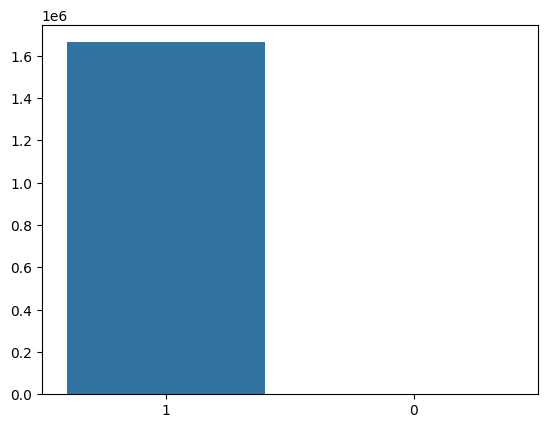

In [29]:
sns.barplot(pts_counter)

0.00042897186453329846

In [23]:
# data/sv/PC3_10_cells_MDA_Mk1c_dirty/chimeric_reads_mapping/cutesv.vcf.sv.read.sup.txt

In [3]:
def load_predicts(path):
    res = {}
    total = 0
    number_label1 = 0
    number_label1_svs = []
    number_label0_svs = []

    with open(path) as f:
        for line in f:
            total += 1
            read, label, sv = line.strip().split(",")
            res[read] = (label, sv)
            if int(label) == 1:
                number_label1 += 1
                number_label1_svs.append(sv)
            elif int(label) == 0:
                number_label0_svs.append(sv)

    print(f"{total=}, {number_label1=}")
    return res, number_label1_svs, number_label0_svs

In [9]:
predict_with_sv = "/projects/b1171/ylk4626/project/Chimera/predicts_with_sv_m10000.txt"

In [10]:
res, number_label1_svs, number_label0_svs = load_predicts(predict_with_sv)

total=40000, number_label1=14259


In [14]:
import matplotlib.pyplot as plt

In [15]:
import seaborn as sns

<Axes: xlabel='count'>

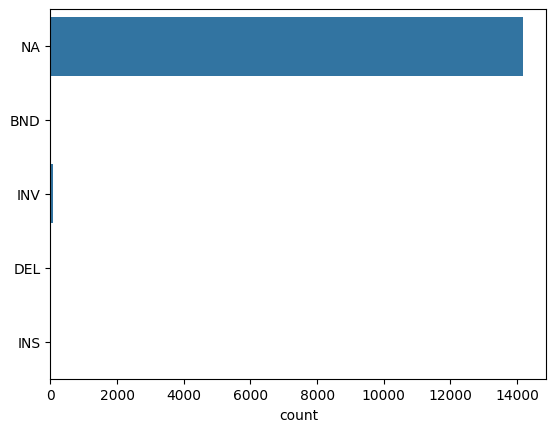

In [16]:
sns.countplot(number_label1_svs)

<Axes: xlabel='count'>

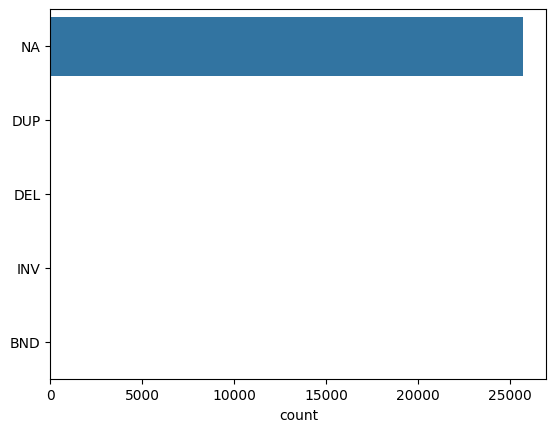

In [17]:
sns.countplot(number_label0_svs)

In [20]:
from collections import Counter

In [21]:
number_label0_svs_counter = Counter(number_label0_svs)

In [22]:
number_label0_svs_counter

Counter({'NA': 25690, 'INV': 31, 'BND': 15, 'DUP': 3, 'DEL': 2})

In [23]:
number_label1_svs_counter = Counter(number_label1_svs)

In [24]:
number_label1_svs_counter

Counter({'NA': 14171, 'INV': 64, 'BND': 19, 'DEL': 3, 'INS': 2})

In [4]:
predict_path = "/projects/b1171/ylk4626/project/Chimera/predicts_with_sv.txt"

In [5]:
res, number_label1_svs, number_label0_svs = load_predicts(predict_path)

total=1000000, number_label1=361582


In [7]:
res

{'9431c005-e850-44a9-b0d0-497308f513a4;41281451-22f4-4b8e-959d-aa0769e1c24d': ('0',
  'NA'),
 'cf7da678-3b67-444f-8cc6-ed201c789f19': ('0', 'NA'),
 '1cd7d883-c921-40e3-9ed3-ee532015115e_1': ('0', 'NA'),
 'e3905a21-e179-4a9b-a8d1-52061e23e82a': ('0', 'NA'),
 '94a0044c-7f7b-443f-a289-8b89f11a968d': ('0', 'NA'),
 '78d031a4-83c2-4a8c-ac2c-7e73bc251739': ('0', 'NA'),
 'e3b6a459-3a9e-42a2-965d-636ef5f16de2': ('1', 'NA'),
 'c91ece19-1302-447c-a43c-fa9fb5c41f88': ('0', 'NA'),
 'c65fe260-ad02-43e5-85b2-b042e2bf1fe4': ('1', 'NA'),
 '883271a6-290a-419b-a3ba-b87fe4962598': ('0', 'NA'),
 '477ce53d-2273-426b-9748-83fb3c6d6fbe': ('0', 'NA'),
 '690eabf9-6588-4e3a-91b3-7786ee80ed54': ('1', 'NA'),
 '5991e64a-a1e6-4d72-be4b-1e8075d2eb64': ('1', 'NA'),
 '8536fe2e-e7c2-42f1-9159-0e1ca97f2a16': ('0', 'NA'),
 'cd66aaec-6251-49ae-a7c4-1c174e69193b': ('0', 'NA'),
 'dddef137-8cca-458d-b19b-b91508d04a2a': ('1', 'NA'),
 '54b21d2e-ca64-4926-9a62-3be0c36ce840': ('0', 'NA'),
 'd2ae09ca-fa34-49ca-81a2-c3116ba6fd20_1'

In [11]:
read_with_label1 = []

for read, label_with_sv in res.items():
    label = label_with_sv[0]

    if label == "1":
        read_with_label1.append(read)

In [12]:
read_with_label1[:10]

['e3b6a459-3a9e-42a2-965d-636ef5f16de2',
 'c65fe260-ad02-43e5-85b2-b042e2bf1fe4',
 '690eabf9-6588-4e3a-91b3-7786ee80ed54',
 '5991e64a-a1e6-4d72-be4b-1e8075d2eb64',
 'dddef137-8cca-458d-b19b-b91508d04a2a',
 'd2ae09ca-fa34-49ca-81a2-c3116ba6fd20_1',
 '8cd65fae-ee9a-4e60-9e41-16d888094247',
 'aa6120ea-9303-49c4-aa1d-da38a2b7b7b1',
 'e0de6b8f-c60b-4c92-a048-07a30fa7dfab',
 'e191ecee-d346-4a7b-a414-617d39e7722c']

In [13]:
len(read_with_label1)

361582

In [14]:
import pysam

In [22]:
bam_path = "/projects/b1171/ylk4626/project/Chimera/data/raw/PC3_10_cells_MDA_Mk1c_dirty.bam"

In [23]:
samfile = pysam.AlignmentFile(bam_path, "rb")

In [ ]:
bam_reads_with_label1 = []

for read in samfile.fetch():
    if read.query_name in read_with_label1:
        bam_reads_with_label1.append(read)

In [ ]:
read_with_label1

In [21]:
with open("selected_reads.txt", "w") as f:
    for read in read_with_label1:
        f.write(f"{read}\n")